# Baseline_model_experiments 

## Explainable Artificial Intelligence for MRI Images of Stroke Patients


### Master of Science in Egineering - Technical Specialization Project II
#### Autor: Loran Avci (avci@zhaw.ch)
#### Supervisors: Dr. Beate Sick (sick@zhaw.ch) , Dr. Helmut Grabner (grbn@zhaw.ch) 



In [1]:
!nvidia-smi

Thu Jul 15 12:27:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:89:00.0 Off |                    2 |
| N/A   23C    P8    10W / 250W |      0MiB / 22919MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

print(tf.__version__)
tf.set_random_seed(3004)
plt.rcParams['figure.figsize'] = 15,15


1.12.0


Using TensorFlow backend.


# Example Patient Visualization

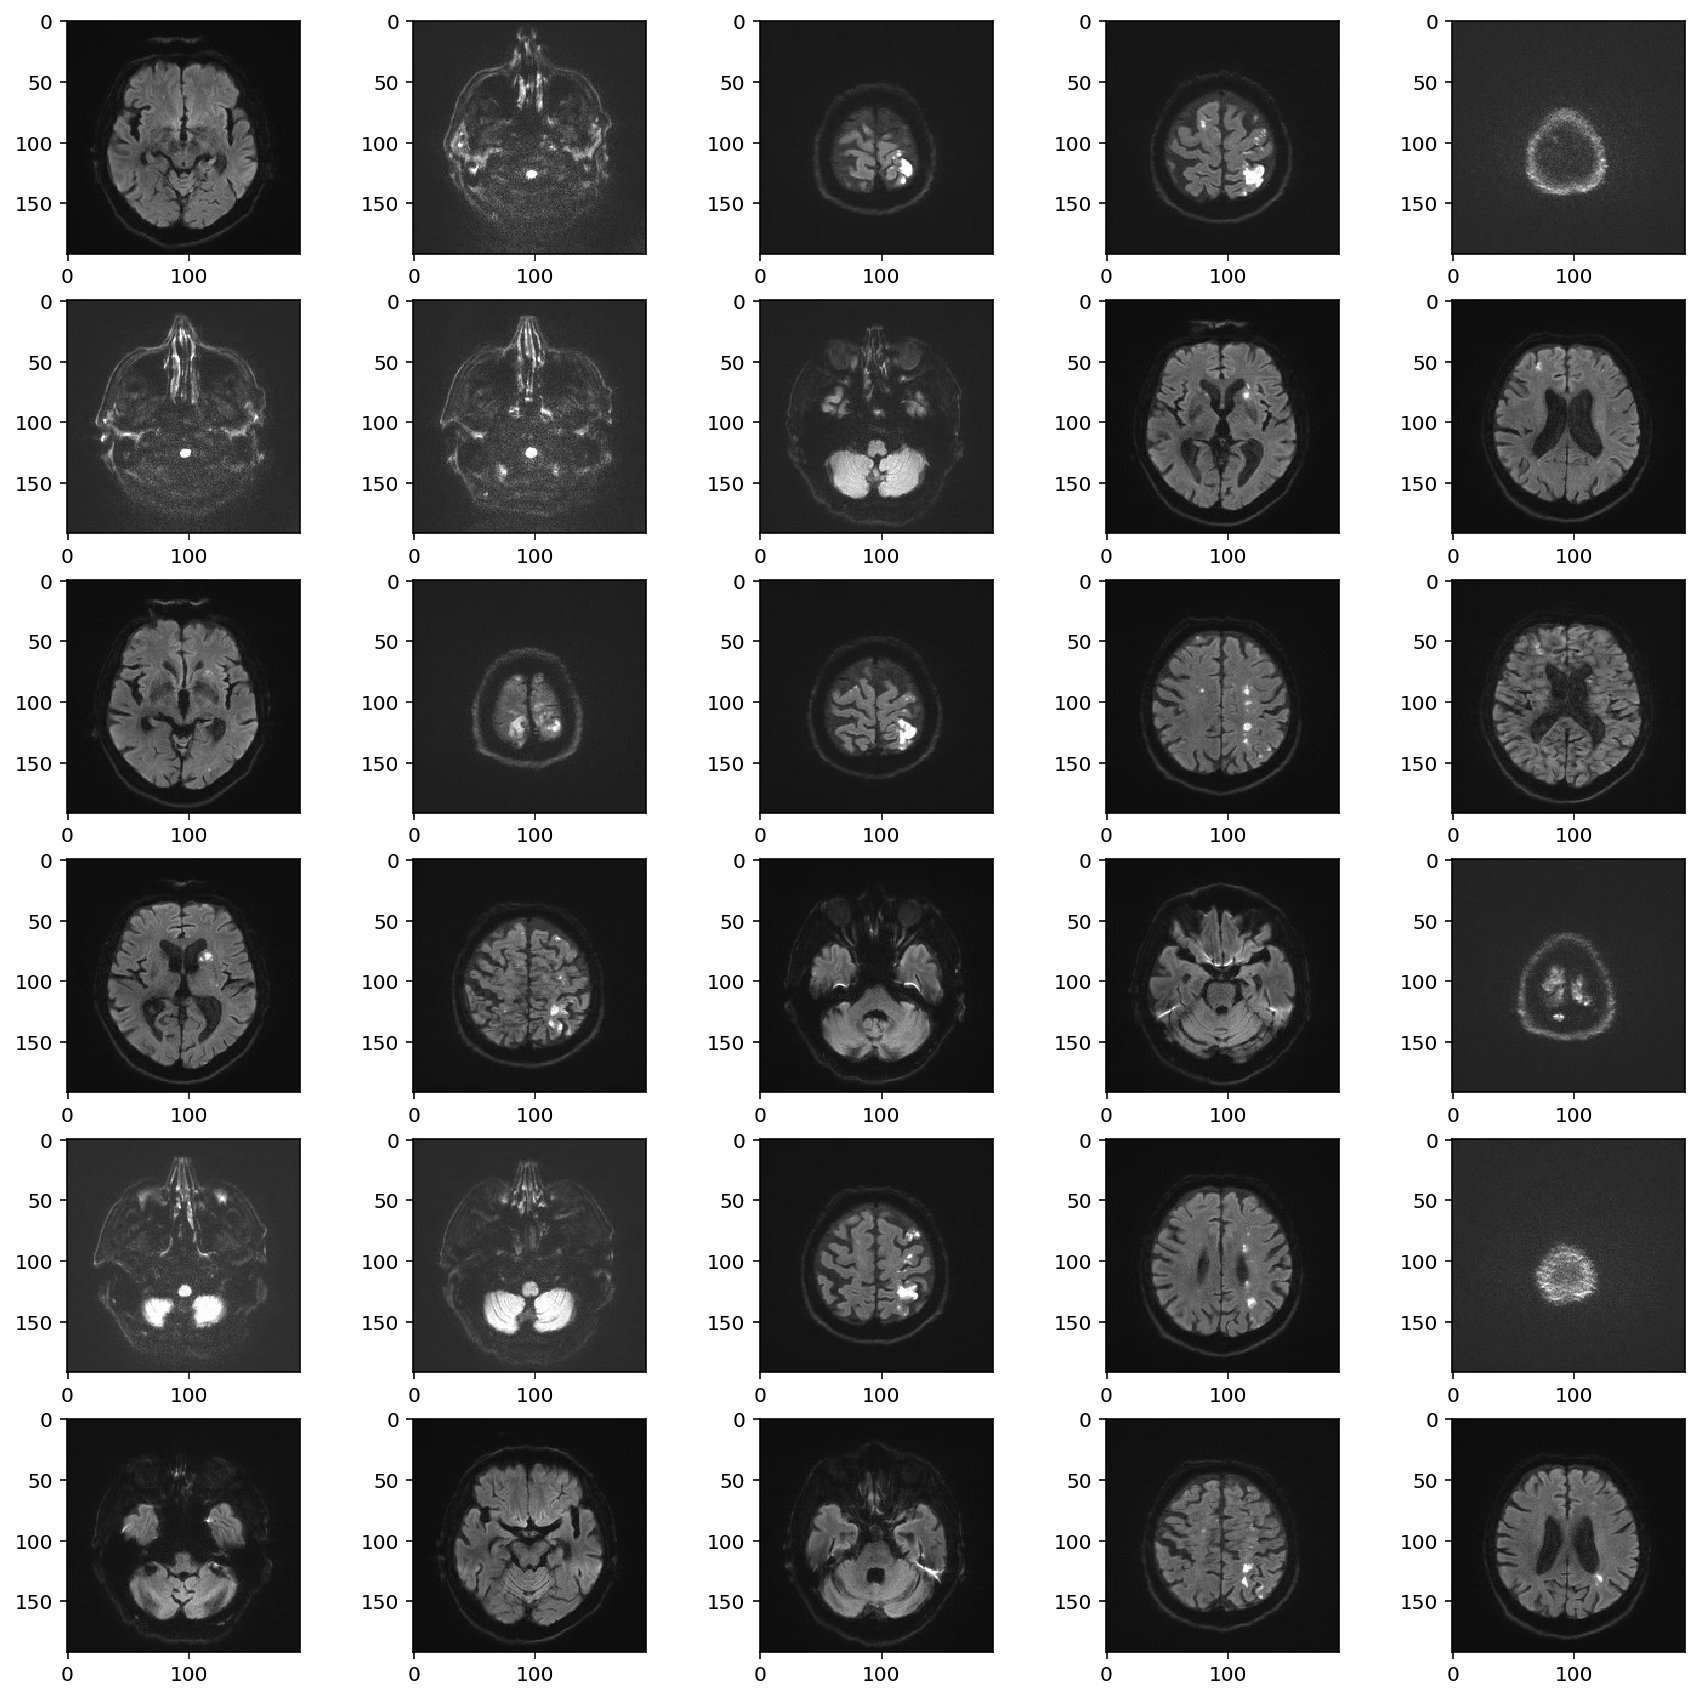

In [3]:
pat_path = "/avci/stroke/Example_patients/stroke_patient_53/*.jpg"
crops = []
for img_path in glob.glob(pat_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    crops.append(img)
    
plt.figure(figsize=(15,15)) # specifying the overall grid size
for i in range(30):
    plt.subplot(6,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(crops[i])
plt.show()

## Cropped Example Patient Visualization

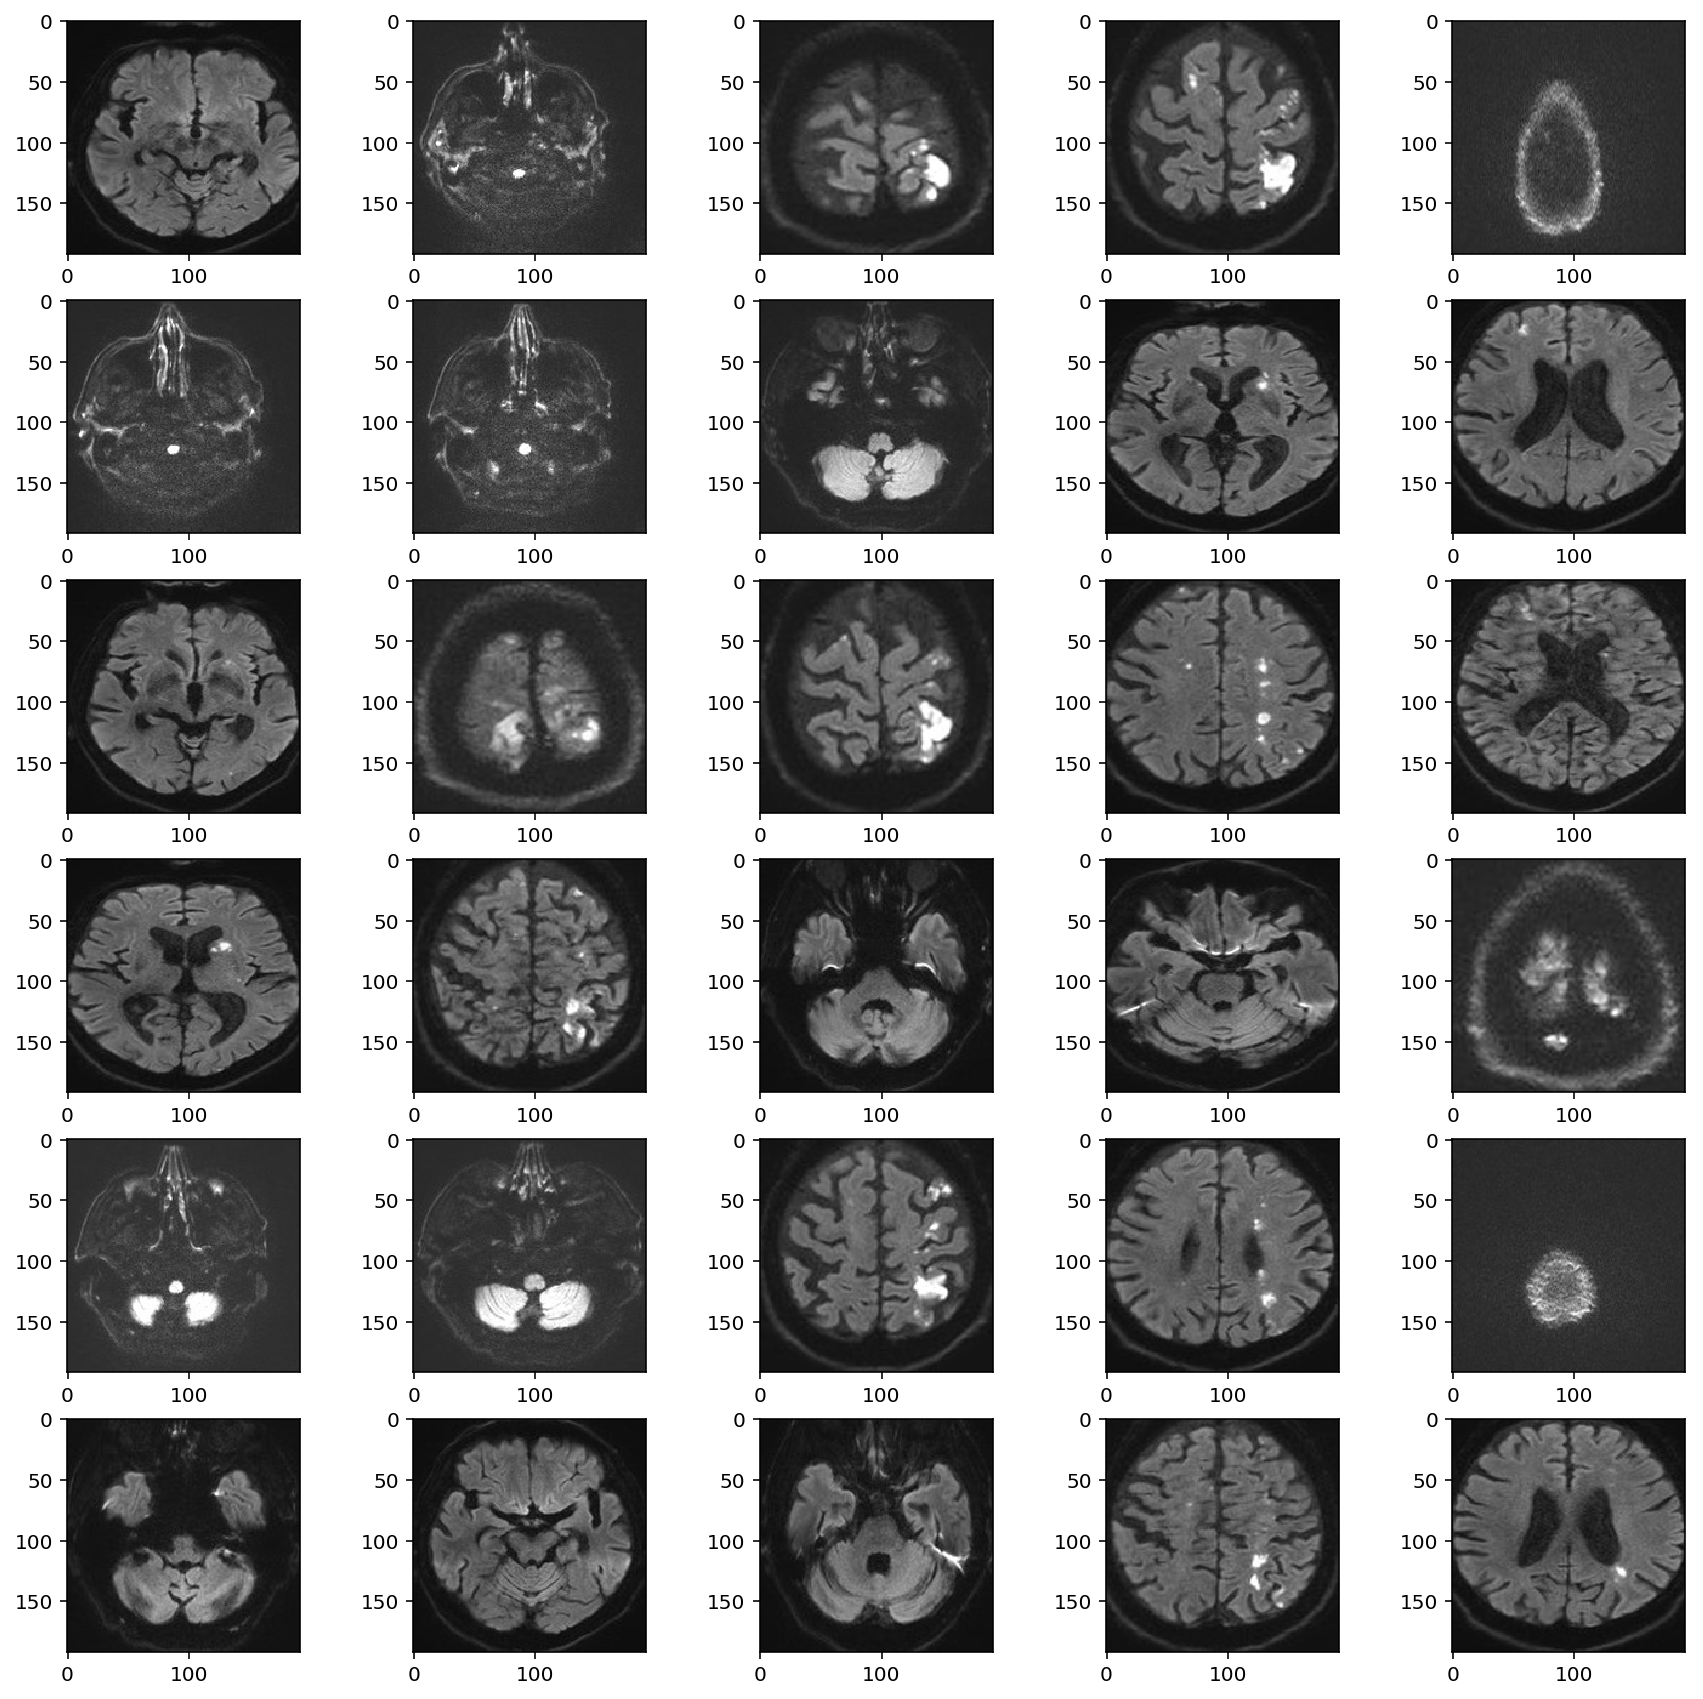

In [4]:
pat_path = "/avci/stroke/Example_patients/stroke_patient_53/*.jpg"
crops = []
for img_path in glob.glob(pat_path):
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold it. I tried a few pixel values, and got something reasonable at min = 5
    _,thresh = cv2.threshold(im,50,255,cv2.THRESH_BINARY)
    # Find contours:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Put all contours together and reshape to (_,2).
    # The first "column" will be your x values of your contours, and second will be y values
    c = np.vstack(contours).reshape(-1,2)
    # Extract the most left, most right, uppermost and lowermost point
    xmin = np.min(c[:,0])
    ymin = np.min(c[:,1])
    xmax = np.max(c[:,0])
    ymax = np.max(c[:,1])
    # Use those as a guide of where to crop your image
    crop = im[ymin:ymax, xmin:xmax]
    crop = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
    crop = cv2.resize(crop, (192,192), interpolation = cv2.INTER_CUBIC)
    crops.append(crop)

plt.figure(figsize=(15,15)) # specifying the overall grid size
for i in range(30):
    plt.subplot(6,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(crops[i])

plt.show()

# Load pre-trained Model

In [ ]:
# start a new session
print('Start new session for predictions')
tf.reset_default_graph()
sess = tf.Session()
K.set_session(sess)
model = keras.models.load_model('/avci/stroke/model-198.hdf5')
K.clear_session()
model.summary()

Start new session for predictions


# Grad-CAM

Gradient-weighted Class Activation Mapping

+ Grad-CAM : https://arxiv.org/pdf/1602.04938v1.pdf
+ Grad-CAM ++ : https://arxiv.org/pdf/1710.11063.pdf

In [ ]:
def grad_cam(input_model, image, layer_name,H=192,W=192, cls=1):

    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    #grads =  (grads + 1e-10) / (K.sqrt(K.mean(K.square(grads))) + 1e-10) # normalize
    gradient_function = K.function([input_model.input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (W, H), cv2.INTER_CUBIC)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0: 
        cam = cam / cam_max
    return cam

def grad_cam_plus(input_model, img, layer_name,H=192,W=192, cls =1):
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads
    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom
    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    #alphas = np.nan_to_num(alphas)
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    # Passing through ReLU
    cam = cv2.resize(grad_CAM_map, (W, H), cv2.INTER_CUBIC)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0: 
        cam = cam / cam_max
    #print(cam)
    return cam

def compare_cam(orig_img, img, temp, mask ,model, cls = 1, l = 'activation_34' ):
    gradcam=grad_cam(model,img,layer_name=l, cls=cls )
    gradcamplus=grad_cam_plus(model,img,layer_name=l,cls=cls )
    print("Saliency Map for Layer:", l)
    print("Saliency Map for class:", cls)
    fig, ax = plt.subplots(nrows=1,ncols=4)
    plt.subplot(141)
    plt.imshow(orig_img)
    plt.title("Input Image")
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.4,cmap="jet")
    plt.title("Grad-CAM: (Stroke)")
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(orig_img)
    plt.imshow(gradcamplus,alpha=0.5,cmap="jet")
    plt.title("Grad-CAM++: (Stroke)")
    plt.axis('off')
    plt.subplot(144)    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("LIME: (Stroke)")
    plt.axis('off')
    plt.show()

# LIME 

Local Interpretable Model-Agnostic Explanations (as Baseline Explanation)

+ LIME : https://arxiv.org/pdf/1602.04938v1.pdf

In [ ]:
img_path = "/avci/stroke/Example_patients/stroke_patient_5/export--511674930.jpg"
img = np.array(load_img(img_path,target_size=(192,192)),dtype=np.float64)
#img = np.fliplr(img)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf").reshape(192,192,3)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model.predict, top_labels=1, hide_color=0, num_samples=500)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


# Experiments

+ 01. Mirroring Images
+ 02. Layer Selection

## Experiment 01 : Mirroring image

In [ ]:
# Mirror image
plt.rcParams['figure.figsize'] = 40,40

#img_path = "/avci/stroke/Example_patients/stroke_patient_53/export--524928113.jpg"
#img_path = "/avci/stroke/Example_patients/stroke_patient_5/export--511674934.jpg"
img_path = "/avci/stroke/Example_patients/stroke_patient_62/export--527865553.jpg"

#preprocess
orig_img = np.array(load_img(img_path,target_size=(192,192)),dtype=np.uint8)
img = np.array(load_img(img_path,target_size=(192,192)),dtype=np.float64)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
# LIME
imgL =img.reshape(192,192,3)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
#predict
predictions = model.predict(img)
print("Prediction Probability:" ,predictions)
#cam
compare_cam(orig_img, img,  temp,mask, model)

# preprocess
orig_img = np.fliplr(np.array(load_img(img_path,target_size=(192,192)),dtype=np.uint8))
img = np.fliplr(np.array(load_img(img_path,target_size=(192,192)),dtype=np.float64))
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
# LIME
imgL =img.reshape(192,192,3)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
#predict
predictions = model.predict(img)
print("Prediction Probability:" ,predictions)
#cam
compare_cam(orig_img, img, temp, mask, model)

### Experiment 01 : Mirroring image - Cropped images

In [ ]:
#img_path = "/avci/stroke/Example_patients/stroke_patient_53/export--524928113.jpg"
#img_path = "/avci/stroke/Example_patients/stroke_patient_5/export--511674934.jpg"
img_path = "/avci/stroke/Example_patients/stroke_patient_62/export--527865553.jpg"

# test with cropped
im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
_,thresh = cv2.threshold(im,25,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = np.vstack(contours).reshape(-1,2)
xmin = np.min(c[:,0])
ymin = np.min(c[:,1])
xmax = np.max(c[:,0])
ymax = np.max(c[:,1])
crop = im[ymin:ymax, xmin:xmax]
img = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
orig_img = img
#preproc
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
#predict
predictions = model.predict(img)
if np.argmax(predictions) == 1:
    print("Prediction Probability:" ,predictions)
    # LIME
    imgL =img.reshape(192,192,3)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
    #cam
    compare_cam(orig_img, img,  temp,mask, model)
    
# test with cropped
im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
_,thresh = cv2.threshold(im,25,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = np.vstack(contours).reshape(-1,2)
xmin = np.min(c[:,0])
ymin = np.min(c[:,1])
xmax = np.max(c[:,0])
ymax = np.max(c[:,1])
crop = im[ymin:ymax, xmin:xmax]
img = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
img = np.fliplr(img) 
orig_img = img
#preproc
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
#predict
predictions = model.predict(img)
if np.argmax(predictions) == 1:
    print("Prediction Probability:" ,predictions)
    # LIME
    imgL =img.reshape(192,192,3)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
    #cam
    compare_cam(orig_img, img,  temp,mask, model)

# Cropped images

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.rcParams['figure.figsize'] =50,50

#pat_path ='/avci/stroke/Example_patients/stroke_patient_19/*.jpg'
#pat_path = '/avci/stroke/Example_patients/**/*.jpg'
pat_path ='/avci/stroke/Example_patients/stroke_patient_53/*.jpg'
pat_path = "/avci/stroke/Example_patients/stroke_patient_53/export--524928117.jpg"


for img_path in glob.glob(pat_path, recursive=True):
    # test with cropped
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _,thresh = cv2.threshold(im,50,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = np.vstack(contours).reshape(-1,2)
    xmin = np.min(c[:,0])
    ymin = np.min(c[:,1])
    xmax = np.max(c[:,0])
    ymax = np.max(c[:,1])
    crop = im[ymin:ymax, xmin:xmax]
    img = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
    orig_img = img
    #preproc
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img, mode= "tf")
    #predict
    predictions = model.predict(img)
    if predictions[0][1] > 0.90:
        print("Prediction Probability:" ,predictions)
        # LIME
        imgL =img.reshape(192,192,3)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
        #cam
        compare_cam(orig_img, img,  temp,mask, model, l= "activation_34")

## Uncropped images

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.rcParams['figure.figsize'] =50,50

#pat_path ='/avci/stroke/Example_patients/stroke_patient_19/*.jpg'
#pat_path = '/avci/stroke/Example_patients/**/*.jpg'
pat_path ='/avci/stroke/Example_patients/stroke_patient_53/*.jpg'


for img_path in glob.glob(pat_path, recursive=True):
    # test with cropped
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    #img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
    orig_img = img
    #preproc
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img, mode= "tf")
    #predict
    predictions = model.predict(img)
    if predictions[0][1] > 0.90:
        print(img_path)
        print("Prediction Probability:" ,predictions)
        # LIME
        imgL =img.reshape(192,192,3)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
        #cam
        compare_cam(orig_img, img,  temp,mask, model)

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.rcParams['figure.figsize'] =50,50

#pat_path ='/avci/stroke/Example_patients/stroke_patient_19/*.jpg'
#pat_path = '/avci/stroke/Example_patients/**/*.jpg'
pat_path ='/avci/stroke/Example_patients/stroke_patient_53/*.jpg'


for img_path in glob.glob(pat_path, recursive=True):
    # test with cropped
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    #img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
    orig_img = img
    #preproc
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img, mode= "tf")
    #predict
    predictions = model.predict(img)
    if predictions[0][1] > 0.90:
        print("Prediction Probability:" ,predictions)
        # LIME
        imgL =img.reshape(192,192,3)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
        #cam
        compare_cam(orig_img, img,  temp,mask, model)

# Itearation over Layers

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.rcParams['figure.figsize'] =50,50

img_path = "/avci/stroke/Example_patients/stroke_patient_62/export--527865553.jpg"

# test with cropped
im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
_,thresh = cv2.threshold(im,25,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = np.vstack(contours).reshape(-1,2)
xmin = np.min(c[:,0])
ymin = np.min(c[:,1])
xmax = np.max(c[:,0])
ymax = np.max(c[:,1])
crop = im[ymin:ymax, xmin:xmax]
img = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
img = np.fliplr(img) 
orig_img = img
#preproc
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
#predict
predictions = model.predict(img)
ll = []
for layer in model.layers:
        ll.append(layer.name)

for l in ll[1:]:
    if np.argmax(predictions) == 1:
        print("Prediction Probability:" ,predictions)
        # LIME
        imgL =img.reshape(192,192,3)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(imgL, model.predict, top_labels=1, hide_color=0, num_samples=500)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
        #cam
        compare_cam(orig_img, img,  temp,mask, model, l= l )

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.rcParams['figure.figsize'] =50,50

img_path = "/avci/stroke/Example_patients/stroke_patient_62/export--527865553.jpg"

# test with cropped
im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
_,thresh = cv2.threshold(im,25,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = np.vstack(contours).reshape(-1,2)
xmin = np.min(c[:,0])
ymin = np.min(c[:,1])
xmax = np.max(c[:,0])
ymax = np.max(c[:,1])
crop = im[ymin:ymax, xmin:xmax]
img = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
orig_img = img
#preproc
img = np.expand_dims(img,axis=0)
img = preprocess_input(img, mode= "tf")
#predict
predictions = model.predict(img)
ll = []
for layer in model.layers:
    if(str.startswith(layer.name, "conv")):
        ll.append(layer.name)
    
n_images = len(ll)
for i,l in enumerate(ll):
    fig = plt.subplot(4,4,i+1)
    gradcam=grad_cam(model,img,layer_name=l, cls=1 )
    fig.imshow(orig_img)
    fig.imshow(gradcam,alpha=0.4,cmap="jet")
    fig.axis('off')
    plt.title(str("Convolutional Layer: " + str(i+1)))
    #fig.show()
  